**First clone the github repository**

In [1]:
#%cd /content
#! git clone https://github.com/Tikquuss/lwd
#%cd lwd/scripts

# **Set-up** 
*Once this section is configured, you can comment (optionally) the previous cell and run everything at once (Runtime -> Run all).*  
**Once everything is executed, a csv file will be automatically created containing all the losses on the test data for each model.**

Uncomment the line corresponding to your function, and choose the value xxx accordingly:
* For Black&Scholes, INPUT_DIM must remain at 1.
* For Gaussian basket options, INPUT_DIM can take any integer value greater than or equal to 1.


In [2]:
f_name = "Black&Scholes"
#f_name = "Gaussian basket options" # vary INPUT_DIM : 1,...,7,..., 20,...

INPUT_DIM = 1

In [3]:
try:
    %tensorflow_version 1.x
    %matplotlib inline
except Exception:
    pass

import torch.nn.functional as F
import torch
import numpy as np
import matplotlib.pyplot as plt
import os

import random

from utils import plot_stat, MLP, Siren, train, test, global_stat, to_csv
from twin_net_tf import graph, get_diffML_data_loader, BlackScholes, Bachelier, test as twin_net_tf_test 
from twin_net_tf_siren import test as twin_net_tf_test_siren

TensorFlow 1.x selected.
1.15.2
False


1.15.2
False


In [4]:
# Global
max_epoch = 1
batch_size = 5
nTrain = 5
nTest = 5
learning_rate = 3e-5
improving_limit = float("inf") # no limit
HIDDEN_DIM = 20
N_HIDDEN = 4
OUTPUT_DIM = 1

# MLP
activation_function = F.softplus
deriv_activation_function = torch.sigmoid # for twin_net_pytorch
mlp_model_kwargs = {"in_features" : INPUT_DIM, # depends on the function
                    "hidden_features" : HIDDEN_DIM, 
                    "hidden_layers" : N_HIDDEN, 
                    "out_features": OUTPUT_DIM, 
                    "activation_function" : activation_function, 
                    "deriv_activation_function" : deriv_activation_function,
                   }

generator_kwargs = {"hidden_units" : HIDDEN_DIM, 
                    "hidden_layers" : N_HIDDEN}

# hyperparameters in the different loss functions to express a tradeoff between y loss and dy loss
loss_config = {'alpha': 1, "beta" : 1} 

# twin_net
train_seed, test_seed = 0, 0
learning_rate_schedule = [(0.0, 1.0e-8), (0.2, 0.1), (0.6, 0.01), (0.9, 1.0e-6), (1.0, 1.0e-8)]

# Siren
first_omega_0 = 30.
hidden_omega_0 = 30.
outermost_linear = True

siren_model_kwargs = {"in_features" : INPUT_DIM, 
                      "hidden_features" : HIDDEN_DIM, 
                      "hidden_layers" : N_HIDDEN, 
                      "out_features": OUTPUT_DIM, 
                      "outermost_linear" : outermost_linear, 
                      "first_omega_0" : first_omega_0, 
                      "hidden_omega_0" : hidden_omega_0}

main_path = "/content"

# **To avoid repeating the same code too much**

In [5]:
def run_train(name, generator, with_derivative, model_class, model_kwargs, normalize, learning_rate_schedule = None):
    
    global nTrain, nTest, train_seed, test_seed, batch_size, learning_rate
    global max_epoch, improving_limit
    global loss_config 

    train_dataloader, test_dataloader, xAxis, vegas, config = get_diffML_data_loader(
        generator = generator, 
        nTrain = nTrain, nTest = nTest, 
        train_seed = train_seed, test_seed = test_seed, batch_size = batch_size, with_derivative = with_derivative,
        normalize = normalize
    )
    
    config["learning_rate_schedule"] = learning_rate_schedule
    config.update(loss_config)
     
    model = model_class(**model_kwargs)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

    model, stats, best_loss = train(name, model, train_dataloader, optimizer, criterion, config, 
                                    with_derivative, max_epoch = max_epoch, improving_limit = improving_limit)
    
    plot_stat(stats, with_derivative = with_derivative)

    (test_loss, r_y, r_dydx), (x_list, y_list, dydx_list, y_pred_list, dydx_pred_list) = test(
        name, model, test_dataloader, criterion, config, with_derivative
    )
    
    xy = [(x[0], y[0]) for x, y in zip(x_list, y_list)]
    xy_pred = [(x[0], y[0]) for x, y in zip(x_list, y_pred_list)]
  
    if with_derivative :
        xdydx = [(x[0], y[0]) for x, y in zip(x_list, dydx_list)]
        xdydx_pred = [(x[0], y) for x, y in zip(x_list, dydx_pred_list)]

        fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize = (15,3))
    else :
        fig, ax1 = plt.subplots(1, 1, sharex=True, figsize = (15,3))

    fig.suptitle('')
    
    ax1.scatter(*zip(*xy), label = "y")
    ax1.scatter(*zip(*xy_pred), label = "ypred")
    ax1.set(xlabel='x', ylabel='y, y_pred')
    ax1.legend()
    if with_derivative :
        ax2.scatter(*zip(*xdydx), label = "dy")
        ax2.scatter(*zip(*xdydx_pred), label = "dy pred")
        ax2.set(xlabel='x', ylabel='dy, dy_pred')
        ax2.legend()
        
    return model, test_loss, stats

def run_diffML_train(name, generator, generator_kwargs, show_graph_per_axis = False, input_dim = None, 
                     siren = False, normalize = True):
    global nTrain, nTest, train_seed, test_seed
    global max_epoch
    global first_omega_0, hidden_omega_0, outermost_linear
    
    if siren :
        dic_loss, regressor, dtrain, dtest, dydxTest, values, deltas, xAxis, vegas = twin_net_tf_test_siren(
              generator, [nTrain], 
              nTrain, nTest, 
              trainSeed = train_seed, testSeed = test_seed, weightSeed = 0, 
              deltidx=0,
              generator_kwargs = generator_kwargs,
              epochs = max_epoch,
              first_omega_0 = first_omega_0, 
              hidden_omega_0 = hidden_omega_0, 
              outermost_linear = outermost_linear,
              normalize = normalize,
              improving_limit = improving_limit
              ) 
    else :
        dic_loss, regressor, dtrain, dtest, dydxTest, values, deltas, xAxis, vegas = twin_net_tf_test(
              generator, [nTrain], 
              nTrain, nTest, 
              trainSeed = train_seed, testSeed = test_seed, weightSeed = 0, 
              deltidx=0,
              generator_kwargs = generator_kwargs,
              normalize = normalize,
              epochs = max_epoch
              )
    
    plot_stat(regressor.stats["normal"], with_derivative = with_derivative)
    plot_stat(regressor.stats["differential"], with_derivative = with_derivative)

    yTest = dtest[1]
    sizes = [nTrain]
    # show predicitions
    graph(name, values, xAxis, "", "values", yTest, [nTrain], True)
    # show deltas
    graph(name, deltas, xAxis, "", "deltas", dydxTest, [nTrain], True)

    if show_graph_per_axis :
        assert input_dim
        for i in range(input_dim) :
            xAxis  = np.array([[x[i]] for x in dtest[0]])
            # show predicitions
            graph("%s x%d vs y" % (name, (i+1)), values, xAxis, "", "values", yTest, [nTrain], True)
            # show deltas
            graph("%s x%d vs dxdy" % (name, (i+1)), deltas, xAxis, "", "deltas", dydxTest, [nTrain], True)

    loss = {"normal" : dic_loss['standard_loss']["yloss"][-1], 
            "differential" : dic_loss['differential_loss']["yloss"][-1]}
    return regressor, loss

In [6]:
if f_name == "Black&Scholes" :
    generator = BlackScholes()
    # for twin_net_tf
    graph_name = "Black & Scholes"
elif f_name == "Gaussian basket options" : 
    generator = Bachelier(n = INPUT_DIM)
    # for twin_net_tf
    graph_name = "Bachelier dimension %d" % INPUT_DIM
    
csv_path = os.path.join(main_path, f_name + ".csv")

stats_dic = {}
tests_loss = {}

# **1) Normal Training**

In [7]:
name = "net"
with_derivative = False
key1 = "normal_training"
stats_dic[key1] = {}
tests_loss[key1] = {}

## **1.1) with MLP**

In [8]:
model_class = MLP
key2 = "mlp"
stats_dic[key1][key2] = {}
tests_loss[key1][key2] = {}

### **1.1.1) normalize = False**

In [9]:
key3 = "no_normalize"
stats_dic[key1][key2][key3] = [None, None]
tests_loss[key1][key2][key3] = [None, None]

Epoch 0: train loss: 0.3708122968673706 train loss no scaled: 0.3708122968673706





test loss: 0.20960882306098938 test loss no scaled 0.20960882306098938


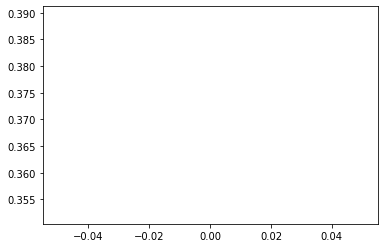

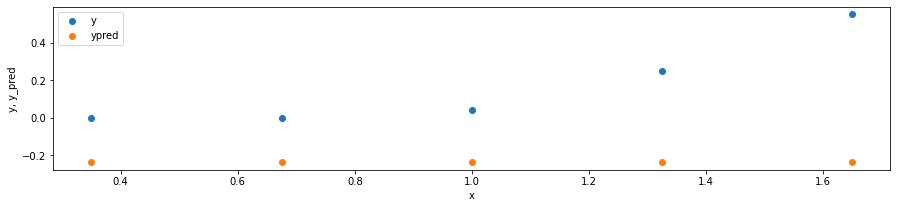

In [10]:
model, tests_loss[key1][key2][key3][0], stats_dic[key1][key2][key3][0] = run_train(
    name = name, 
    generator = generator, 
    with_derivative = with_derivative, 
    model_class = model_class, 
    model_kwargs = mlp_model_kwargs,
    normalize = False, 
    learning_rate_schedule = None)

Epoch 0: train loss: 0.19412939250469208 train loss no scaled: 0.19412939250469208





test loss: 0.09370336681604385 test loss no scaled 0.09370336681604385


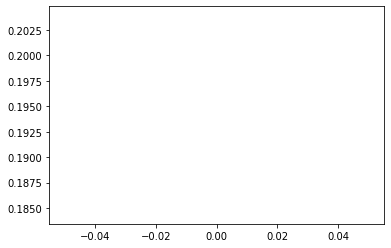

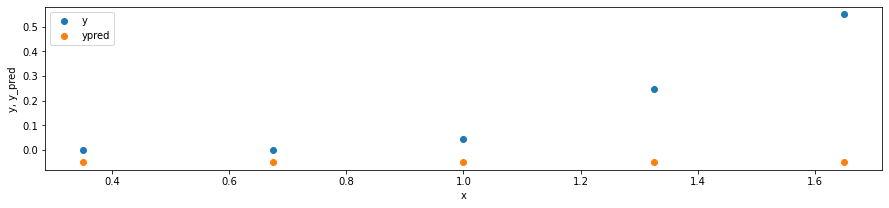

In [11]:
model, tests_loss[key1][key2][key3][1], stats_dic[key1][key2][key3][1] = run_train(
    name = name, 
    generator = generator, 
    with_derivative = with_derivative, 
    model_class = model_class, 
    model_kwargs = mlp_model_kwargs,
    normalize = False, 
    learning_rate_schedule = learning_rate_schedule)

### **1.1.2) normalize = True**

In [12]:
key3 = "normalize"
stats_dic[key1][key2][key3] = [None, None]
tests_loss[key1][key2][key3] = [None, None]

Epoch 0: train loss: 1.129440188407898 train loss no scaled: 0.054108393726577





test loss: 1.0861930722099533 test loss no scaled 0.052036542714407136


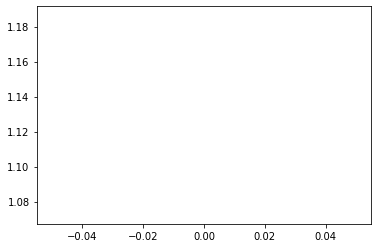

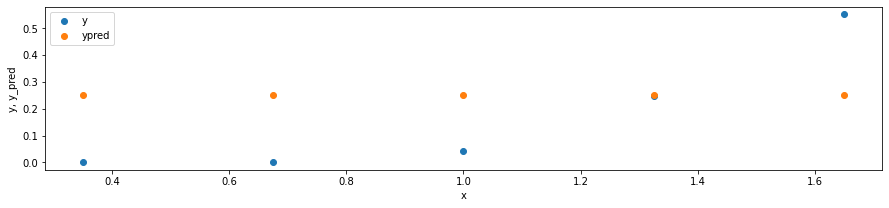

In [13]:
model, tests_loss[key1][key2][key3][0], stats_dic[key1][key2][key3][0] = run_train(
    name = name, 
    generator = generator, 
    with_derivative = with_derivative, 
    model_class = model_class, 
    model_kwargs = mlp_model_kwargs,
    normalize = True, 
    learning_rate_schedule = None)

Epoch 0: train loss: 1.0821841955184937 train loss no scaled: 0.051844484020842053





test loss: 1.1485920527030595 test loss no scaled 0.05502590740180899


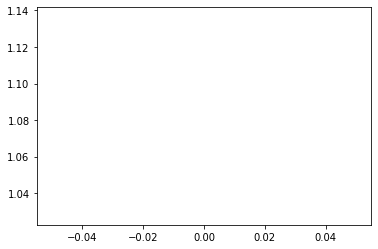

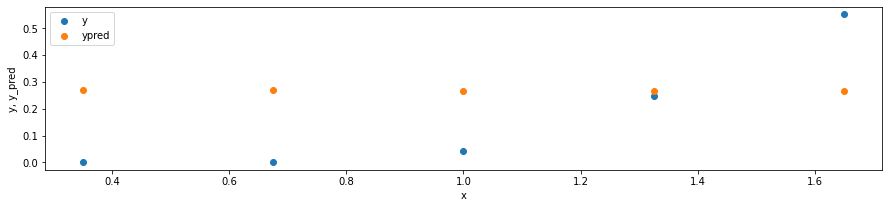

In [14]:
model, tests_loss[key1][key2][key3][1], stats_dic[key1][key2][key3][1] = run_train(
    name = name, 
    generator = generator, 
    with_derivative = with_derivative, 
    model_class = model_class, 
    model_kwargs = mlp_model_kwargs,
    normalize = True, 
    learning_rate_schedule = learning_rate_schedule)

## **1.2) with Siren**

In [15]:
model_class = Siren
key2 = "siren"
stats_dic[key1][key2] = {}
tests_loss[key1][key2] = {}


### **1.2.1) normalize = False**

In [16]:
key3 = "no_normalize"
stats_dic[key1][key2][key3] = [None, None]
tests_loss[key1][key2][key3] = [None, None]

Epoch 0: train loss: 0.14305299520492554 train loss no scaled: 0.14305299520492554





test loss: 0.07008551806211472 test loss no scaled 0.07008551806211472


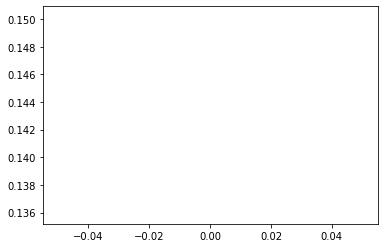

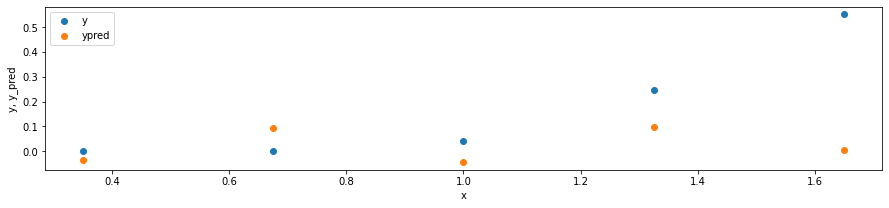

In [17]:
model, tests_loss[key1][key2][key3][0], stats_dic[key1][key2][key3][0] = run_train(
    name = name, 
    generator = generator, 
    with_derivative = with_derivative, 
    model_class = model_class, 
    model_kwargs = siren_model_kwargs,
    normalize = False, 
    learning_rate_schedule = None)

Epoch 0: train loss: 0.18307524919509888 train loss no scaled: 0.18307524919509888





test loss: 0.085685595870018 test loss no scaled 0.085685595870018


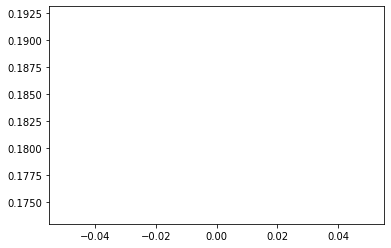

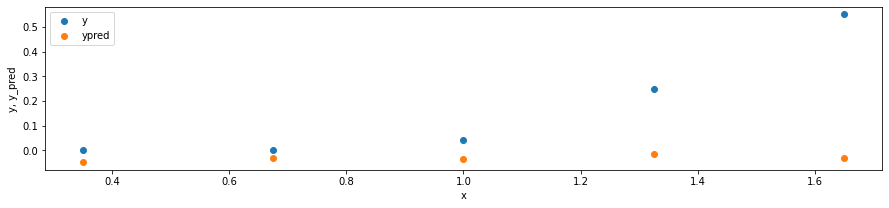

In [18]:
model, tests_loss[key1][key2][key3][1], stats_dic[key1][key2][key3][1] = run_train(
    name = name, 
    generator = generator, 
    with_derivative = with_derivative, 
    model_class = model_class, 
    model_kwargs = siren_model_kwargs,
    normalize = False, 
    learning_rate_schedule = learning_rate_schedule)

### **1.2.2) normalize = True**

In [19]:
key3 = "normalize"
stats_dic[key1][key2][key3] = [None, None]
tests_loss[key1][key2][key3] = [None, None]

Epoch 0: train loss: 1.000576376914978 train loss no scaled: 0.0479348779129054





test loss: 1.5220890396413802 test loss no scaled 0.07291912768812062


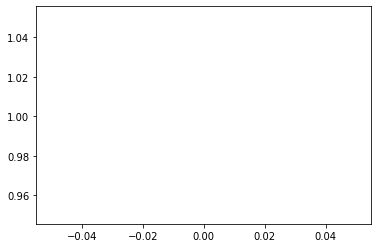

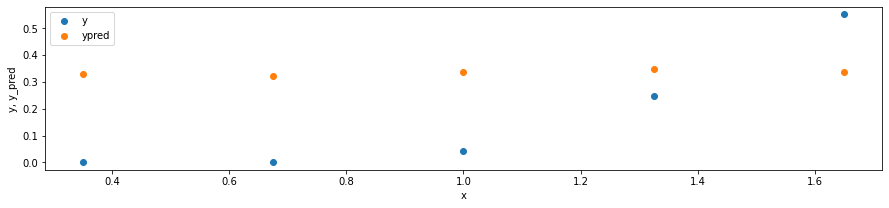

In [20]:
model, tests_loss[key1][key2][key3][0], stats_dic[key1][key2][key3][0] = run_train(
    name = name, 
    generator = generator, 
    with_derivative = with_derivative, 
    model_class = model_class, 
    model_kwargs = siren_model_kwargs,
    normalize = True, 
    learning_rate_schedule = None)

Epoch 0: train loss: 1.0220370292663574 train loss no scaled: 0.04896299620967614





test loss: 1.258421938128249 test loss no scaled 0.060287557167829256


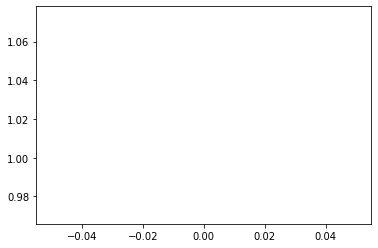

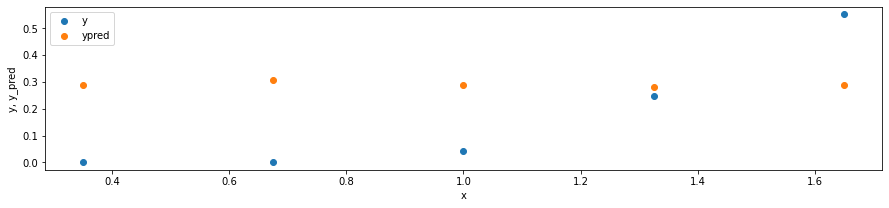

In [21]:
model, tests_loss[key1][key2][key3][1], stats_dic[key1][key2][key3][1] = run_train(
    name = name, 
    generator = generator, 
    with_derivative = with_derivative, 
    model_class = model_class, 
    model_kwargs = siren_model_kwargs,
    normalize = True, 
    learning_rate_schedule = learning_rate_schedule)

# **2) Sobolev Training**

In [22]:
name = "net"
with_derivative = True
key1 = "sobolev_training"
stats_dic[key1] = {}
tests_loss[key1] = {}

## **2.1) with MLP**

In [23]:
model_class = MLP
key2 = "mlp"
stats_dic[key1][key2] = {}
tests_loss[key1][key2] = {}

### **2.1.1) normalize = False**

In [24]:
key3 = "no_normalize"
stats_dic[key1][key2][key3] = [None, None]
tests_loss[key1][key2][key3] = [None, None]

Epoch 0: train loss: 1.1500353813171387, y loss : 0.45079582929611206, dy loss : 0.6992396116256714

train loss no scaled: 1.1500354409217834, y loss  no scaled : 0.45079582929611206, dy loss  no scaled: 0.6992396116256714






test loss: 1.0503041744232178, y loss : 0.6754295229911804, dydx loss : 0.37487465143203735

test loss no scaled: 1.0503041744232178, y loss  no scaled : 0.6754295229911804, dydx loss  no scaled: 0.37487465143203735




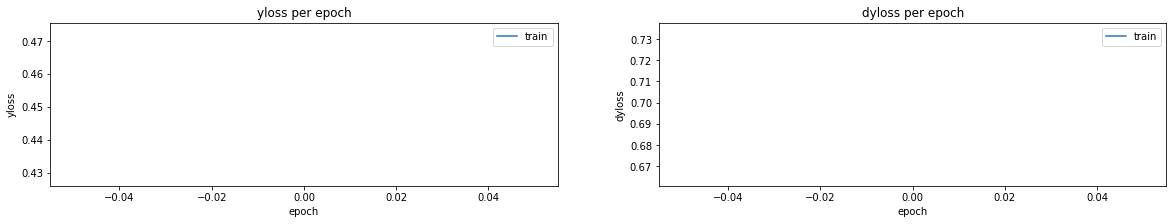

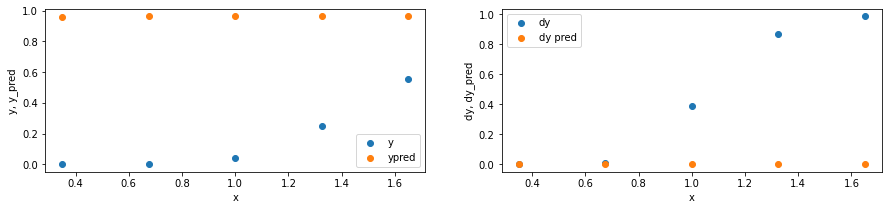

In [25]:
model, tests_loss[key1][key2][key3][0], stats_dic[key1][key2][key3][0] = run_train(
    name = name, 
    generator = generator, 
    with_derivative = with_derivative, 
    model_class = model_class, 
    model_kwargs = mlp_model_kwargs,
    normalize = False, 
    learning_rate_schedule = None)

Epoch 0: train loss: 1.2790260314941406, y loss : 0.571276068687439, dy loss : 0.7077499628067017

train loss no scaled: 1.2790260314941406, y loss  no scaled : 0.571276068687439, dy loss  no scaled: 0.7077499628067017






test loss: 1.2072441577911377, y loss : 0.8272696137428284, dydx loss : 0.3799746036529541

test loss no scaled: 1.2072442173957825, y loss  no scaled : 0.8272696137428284, dydx loss  no scaled: 0.3799746036529541




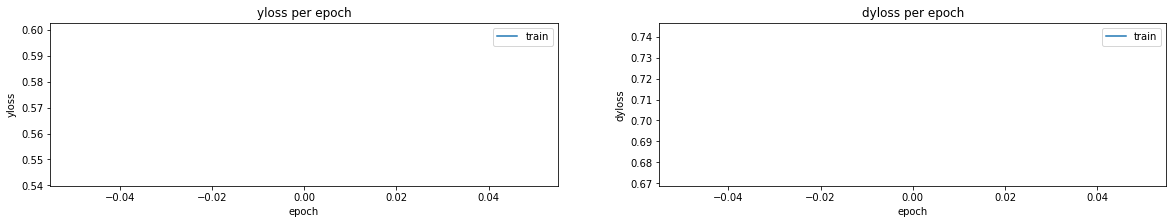

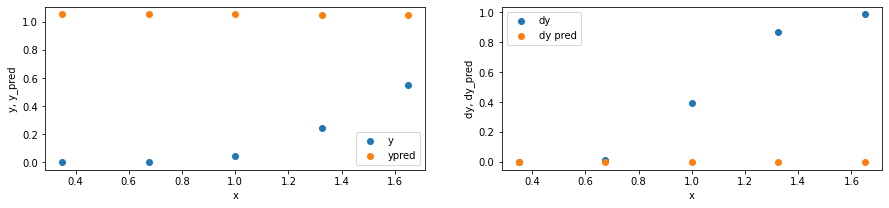

In [26]:
model, tests_loss[key1][key2][key3][1], stats_dic[key1][key2][key3][1] = run_train(
    name = name, 
    generator = generator, 
    with_derivative = with_derivative, 
    model_class = model_class, 
    model_kwargs = mlp_model_kwargs,
    normalize = False, 
    learning_rate_schedule = learning_rate_schedule)

### **2.1.2) normalize = True**

In [27]:
key3 = "normalize"
stats_dic[key1][key2][key3] = [None, None]
tests_loss[key1][key2][key3] = [None, None]

Epoch 0: train loss: 2.5069408416748047, y loss : 1.506786823272705, dy loss : 1.00015389919281

train loss no scaled: 0.21867979100624457, y loss  no scaled : 0.07218604473040686, dy loss  no scaled: 0.1464937462758377






test loss: 4.8065424269755965, y loss : 3.0391212925983746, dydx loss : 1.7674211343772221

test loss no scaled: 0.4044723037215988, y loss  no scaled : 0.14559599854084795, dydx loss  no scaled: 0.25887630518075083




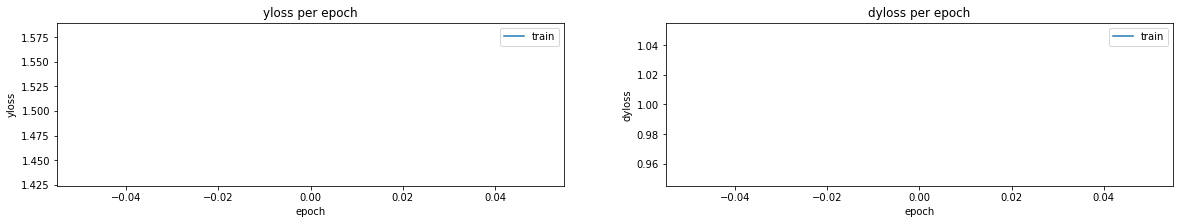

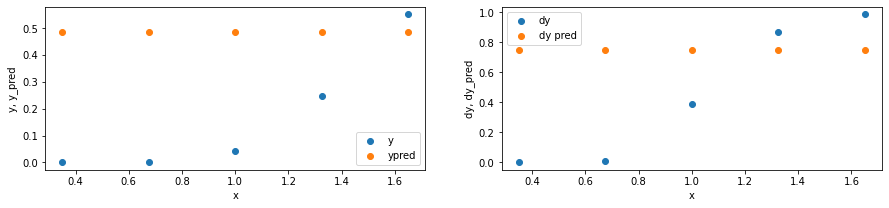

In [28]:
model, tests_loss[key1][key2][key3][0], stats_dic[key1][key2][key3][0] = run_train(
    name = name, 
    generator = generator, 
    with_derivative = with_derivative, 
    model_class = model_class, 
    model_kwargs = mlp_model_kwargs,
    normalize = True, 
    learning_rate_schedule = None)

Epoch 0: train loss: 2.335847854614258, y loss : 1.3361150026321411, dy loss : 0.9997328519821167

train loss no scaled: 0.2104416956784334, y loss  no scaled : 0.06400962103144997, dy loss  no scaled: 0.14643207464698343






test loss: 2.7342854161764616, y loss : 0.9683634404223063, dydx loss : 1.7659219757541553

test loss no scaled: 0.30504836856384476, y loss  no scaled : 0.04639164695470043, dydx loss  no scaled: 0.2586567216091443




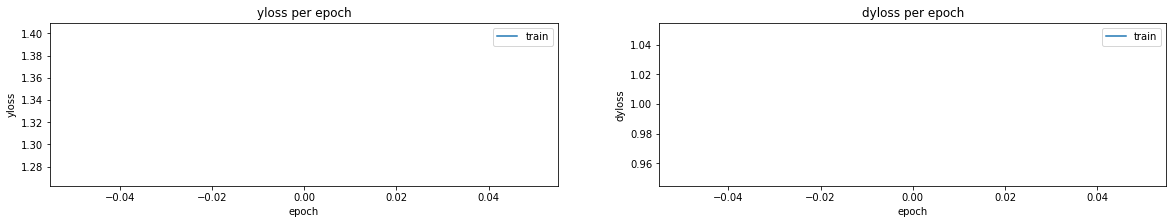

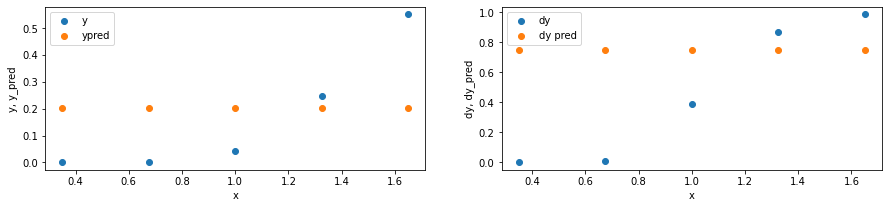

In [29]:
model, tests_loss[key1][key2][key3][1], stats_dic[key1][key2][key3][1] = run_train(
    name = name, 
    generator = generator, 
    with_derivative = with_derivative, 
    model_class = model_class, 
    model_kwargs = mlp_model_kwargs,
    normalize = True, 
    learning_rate_schedule = learning_rate_schedule)

## **2.2) with Siren**

In [30]:
model_class = Siren
key2 = "siren"
stats_dic[key1][key2] = {}
tests_loss[key1][key2] = {}

### **2.2.1) normalize = False**

In [31]:
key3 = "no_normalize"
stats_dic[key1][key2][key3] = [None, None]
tests_loss[key1][key2][key3] = [None, None]

Epoch 0: train loss: 1.5601756572723389, y loss : 0.2070188671350479, dy loss : 1.3531568050384521

train loss no scaled: 1.5601756721735, y loss  no scaled : 0.2070188671350479, dy loss  no scaled: 1.3531568050384521






test loss: 1.120382308959961, y loss : 0.09640214592218399, dydx loss : 1.0239801406860352

test loss no scaled: 1.1203822866082191, y loss  no scaled : 0.09640214592218399, dydx loss  no scaled: 1.0239801406860352




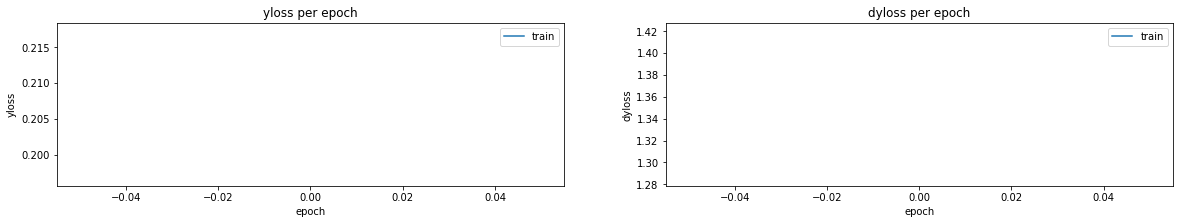

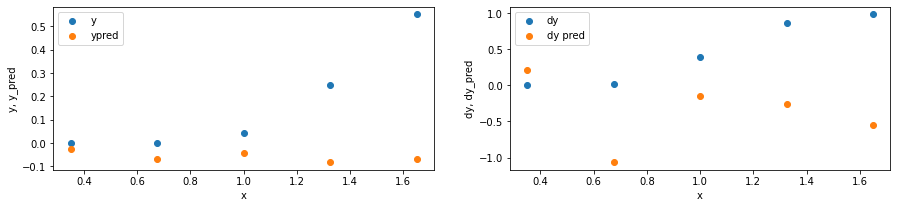

In [32]:
model, tests_loss[key1][key2][key3][0], stats_dic[key1][key2][key3][0] = run_train(
    name = name, 
    generator = generator, 
    with_derivative = with_derivative, 
    model_class = model_class, 
    model_kwargs = siren_model_kwargs,
    normalize = False, 
    learning_rate_schedule = None)

Epoch 0: train loss: 0.9729297161102295, y loss : 0.13498185575008392, dy loss : 0.8379478454589844

train loss no scaled: 0.9729297012090683, y loss  no scaled : 0.13498185575008392, dy loss  no scaled: 0.8379478454589844






test loss: 1.1730146408081055, y loss : 0.06598209589719772, dydx loss : 1.1070325374603271

test loss no scaled: 1.1730146333575249, y loss  no scaled : 0.06598209589719772, dydx loss  no scaled: 1.1070325374603271




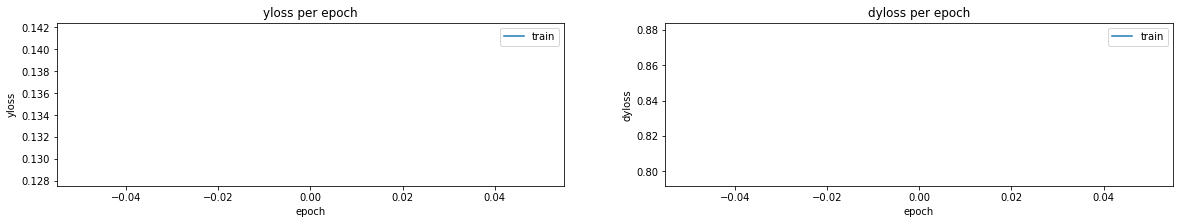

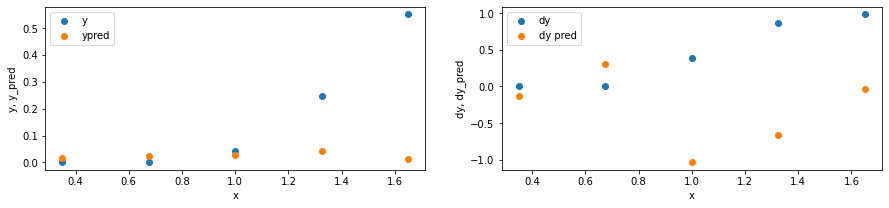

In [33]:
model, tests_loss[key1][key2][key3][1], stats_dic[key1][key2][key3][1] = run_train(
    name = name, 
    generator = generator, 
    with_derivative = with_derivative, 
    model_class = model_class, 
    model_kwargs = siren_model_kwargs,
    normalize = False, 
    learning_rate_schedule = learning_rate_schedule)

### **2.2.2) normalize = True**

In [34]:
key3 = "normalize"
stats_dic[key1][key2][key3] = [None, None]
tests_loss[key1][key2][key3] = [None, None]

Epoch 0: train loss: 2.2655649185180664, y loss : 1.0241689682006836, dy loss : 1.2413960695266724

train loss no scaled: 0.23089393085399482, y loss  no scaled : 0.04906514170706908, dy loss  no scaled: 0.18182878914692574






test loss: 2.8329724946163477, y loss : 1.2793788794207914, dydx loss : 1.5535936151955565

test loss no scaled: 0.28884827752867553, y loss  no scaled : 0.06129154697280374, dydx loss  no scaled: 0.2275567305558718




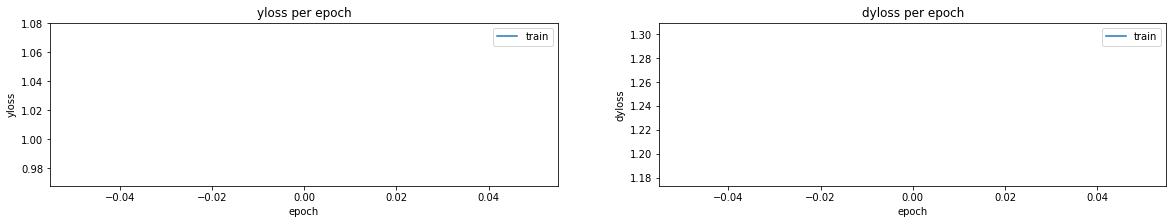

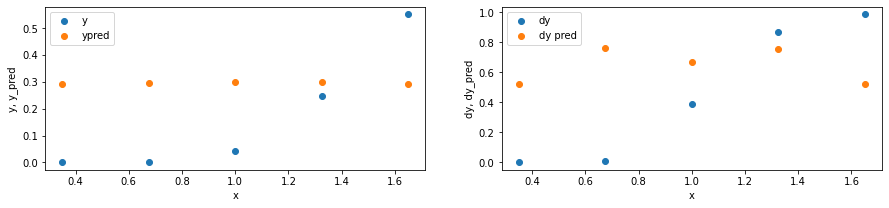

In [35]:
model, tests_loss[key1][key2][key3][0], stats_dic[key1][key2][key3][0] = run_train(
    name = name, 
    generator = generator, 
    with_derivative = with_derivative, 
    model_class = model_class, 
    model_kwargs = siren_model_kwargs,
    normalize = True, 
    learning_rate_schedule = None)

Epoch 0: train loss: 2.391995668411255, y loss : 1.0425560474395752, dy loss : 1.3494396209716797

train loss no scaled: 0.24760005107750074, y loss  no scaled : 0.049946015576957874, dy loss  no scaled: 0.19765403550054286






test loss: 4.015584474122212, y loss : 1.2217360214286208, dydx loss : 2.7938484526935916

test loss no scaled: 0.4677483875559419, y loss  no scaled : 0.05853003512115173, dydx loss  no scaled: 0.40921835243479016




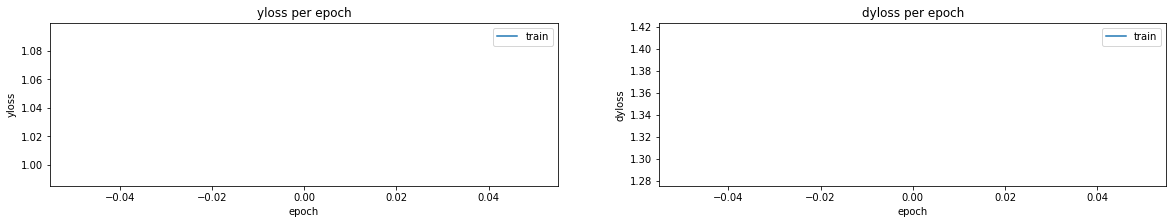

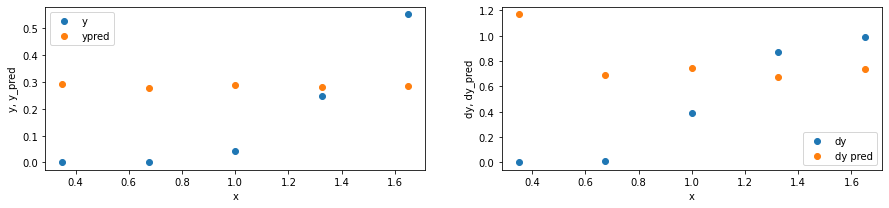

In [36]:
model, tests_loss[key1][key2][key3][1], stats_dic[key1][key2][key3][1] = run_train(
    name = name, 
    generator = generator, 
    with_derivative = with_derivative, 
    model_class = model_class, 
    model_kwargs = siren_model_kwargs,
    normalize = True, 
    learning_rate_schedule = learning_rate_schedule)

# **3) twin_net tensorflow**

In [37]:
key1 = "twin_net_tf"
key1_1 = "%s_normal" % key1
key1_2 = "%s_differential" % key1
stats_dic[key1_1] = {}
stats_dic[key1_2] = {}
tests_loss[key1_1] = {}
tests_loss[key1_2] = {}

## **3.1) with MLP**

In [38]:
key2 = "mlp"
stats_dic[key1_1][key2] = {}
stats_dic[key1_2][key2] = {}
tests_loss[key1_1][key2] = {}
tests_loss[key1_2][key2] = {}

### **3.1.1) normalize = False**

simulating training, valid and test sets
done
initializing neural appropximator
done

size 5


Epoch 0: y loss scaled : 0.2719725966453552, dy loss _scaled : 0.8849661946296692

y loss no scaled : 0.2719725966453552, dy loss no scaled : 0.8849661946296692



test y loss : 0.13613620400428772, test dy loss : 0.4811077117919922


Epoch 0: y loss scaled : 0.27197265625, dy loss _scaled : 0.8849660754203796

y loss no scaled : 0.27197265625, dy loss no scaled : 0.8849660754203796



test y loss : 0.1361362338066101, test dy loss : 0.4811077117919922


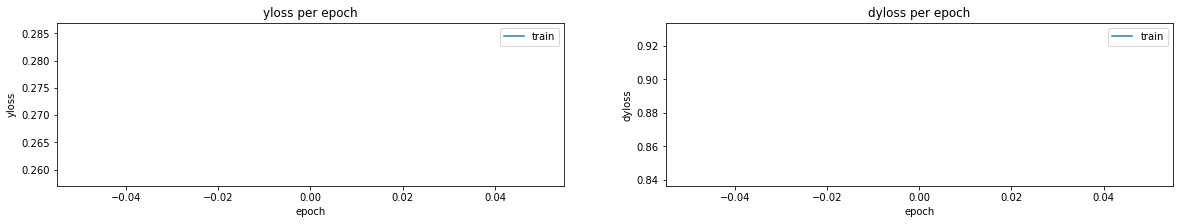

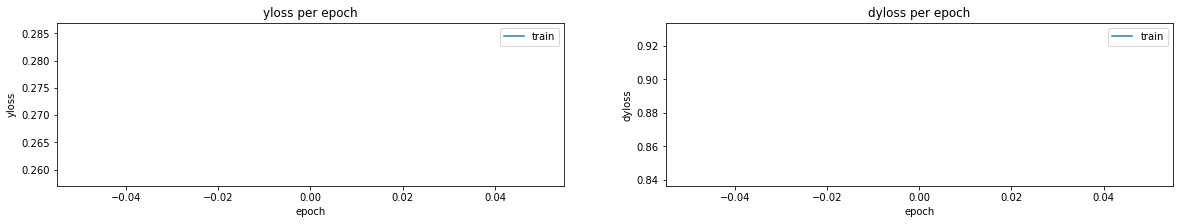

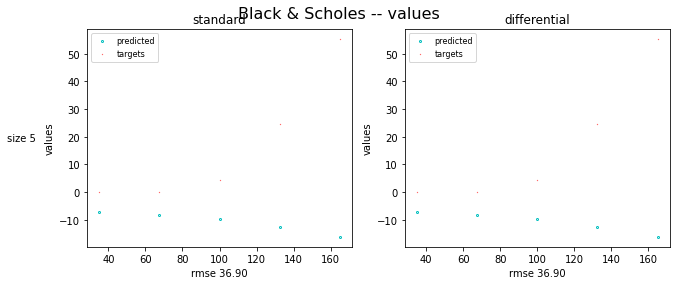

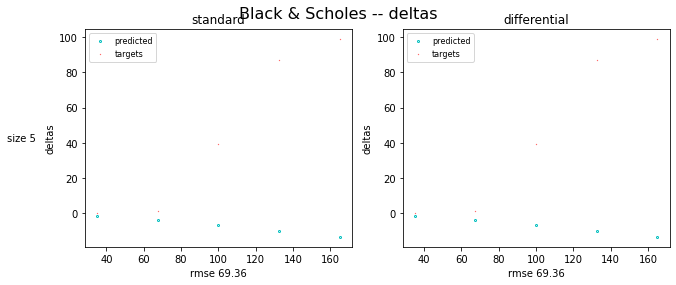

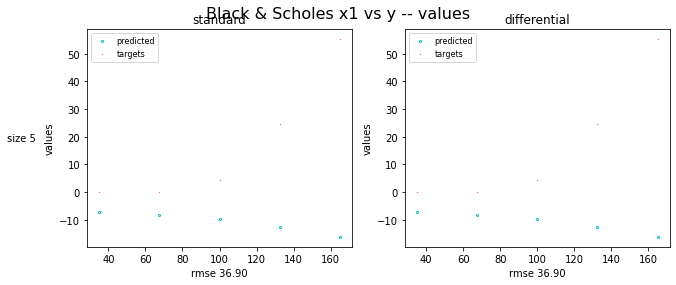

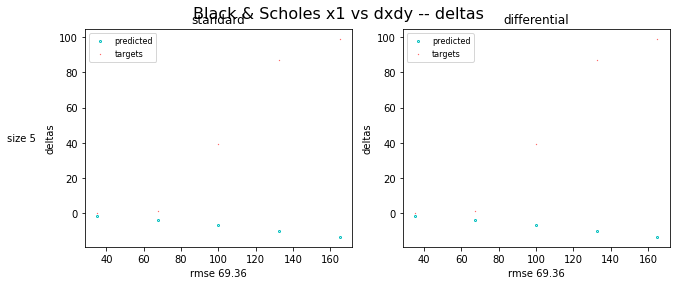

In [39]:
key3 = "no_normalize"
stats_dic[key1_1][key2][key3] = [None, None]
stats_dic[key1_2][key2][key3] = [None, None]
tests_loss[key1_1][key2][key3] = [None, None]
tests_loss[key1_2][key2][key3] = [None, None]

model, loss = run_diffML_train(
              name = graph_name, 
              generator = generator, 
              generator_kwargs = generator_kwargs ,
              show_graph_per_axis = True, 
              input_dim = INPUT_DIM,
              normalize = False
              )
stats_dic[key1_1][key2][key3][0] = stats_dic[key1_1][key2][key3][1] = model.stats["normal"]
stats_dic[key1_2][key2][key3][0] = stats_dic[key1_2][key2][key3][1] = model.stats["differential"]
tests_loss[key1_1][key2][key3][0] = tests_loss[key1_1][key2][key3][1] = loss["normal"]
tests_loss[key1_2][key2][key3][0] = tests_loss[key1_2][key2][key3][1] = loss["differential"]

### **3.1.2) normalize = True**

simulating training, valid and test sets
done
initializing neural appropximator
done

size 5


Epoch 0: y loss scaled : 1.0157169103622437, dy loss _scaled : 1.1467595100402832

y loss no scaled : 0.048660218715667725, dy loss no scaled : 1.767514944076538



test y loss : 0.06429554522037506, test dy loss : 0.3965555727481842


Epoch 0: y loss scaled : 1.0157169103622437, dy loss _scaled : 1.1467595100402832

y loss no scaled : 0.048660218715667725, dy loss no scaled : 1.7675148248672485



test y loss : 0.06429553031921387, test dy loss : 0.3965555727481842


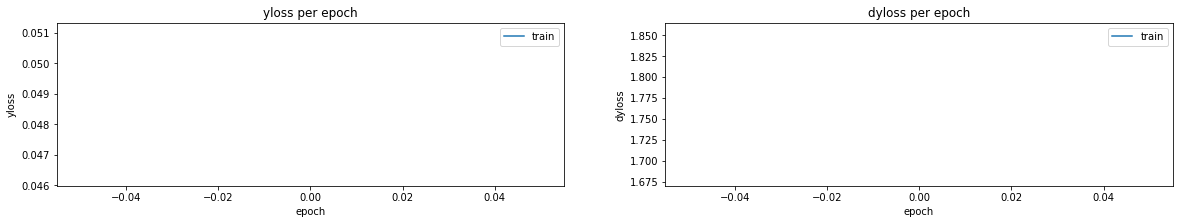

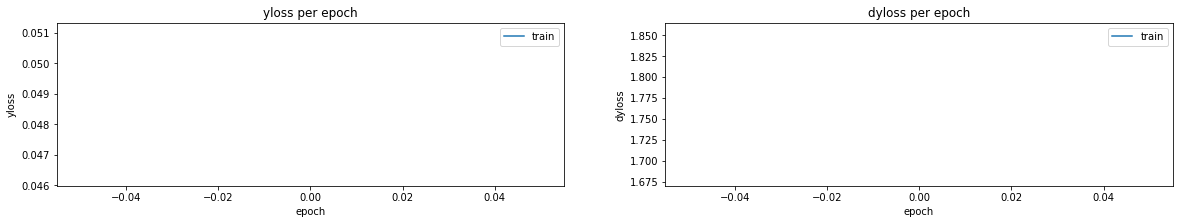

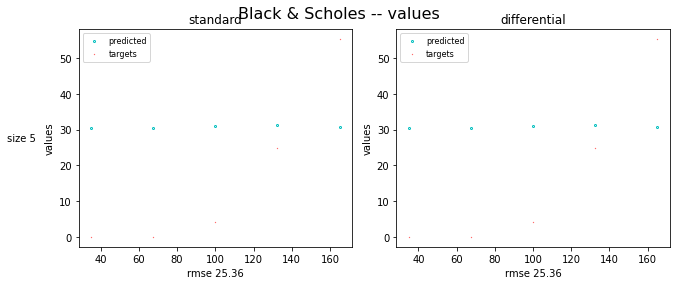

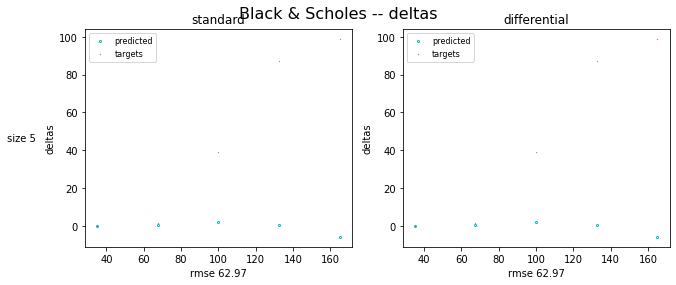

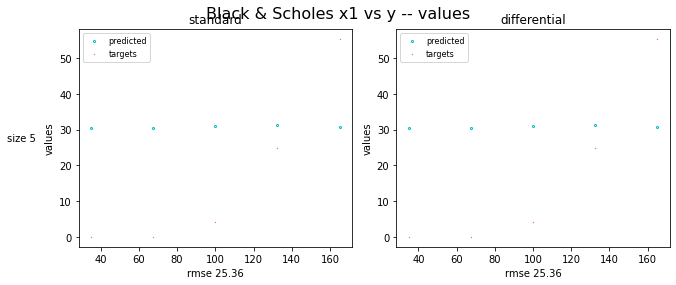

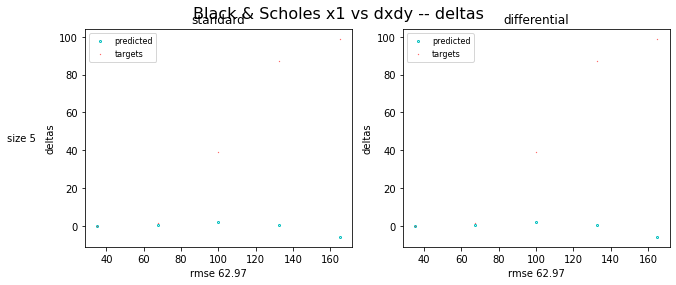

In [40]:
key3 = "normalize"
stats_dic[key1_1][key2][key3] = [None, None]
stats_dic[key1_2][key2][key3] = [None, None]
tests_loss[key1_1][key2][key3] = [None, None]
tests_loss[key1_2][key2][key3] = [None, None]

model, loss = run_diffML_train(
              name = graph_name, 
              generator = generator, 
              generator_kwargs = generator_kwargs ,
              show_graph_per_axis = True, 
              input_dim = INPUT_DIM,
              normalize = True
              )

stats_dic[key1_1][key2][key3][0] = stats_dic[key1_1][key2][key3][1] = model.stats["normal"]
stats_dic[key1_2][key2][key3][0] = stats_dic[key1_2][key2][key3][1] = model.stats["differential"]
tests_loss[key1_1][key2][key3][0] = tests_loss[key1_1][key2][key3][1] = loss["normal"]
tests_loss[key1_2][key2][key3][0] = tests_loss[key1_2][key2][key3][1] = loss["differential"]

## **3.2) with Siren**

In [41]:
key2 = "siren"
stats_dic[key1_1][key2] = {}
stats_dic[key1_2][key2] = {}
tests_loss[key1_1][key2] = {}
tests_loss[key1_2][key2] = {}

### **3.2.1) normalize = False**

simulating training, valid and test sets
done
initializing neural appropximator
done

size 5


Epoch 0: y loss scaled : 5.13663387298584, dy loss _scaled : 231.3736114501953

y loss no scaled : 5.13663387298584, dy loss no scaled : 231.3736114501953



test y loss : 5.608599662780762, test dy loss : 513.3026123046875


Epoch 0: y loss scaled : 5.136781215667725, dy loss _scaled : 231.343505859375

y loss no scaled : 5.136781215667725, dy loss no scaled : 231.343505859375



test y loss : 5.608695983886719, test dy loss : 513.3209228515625


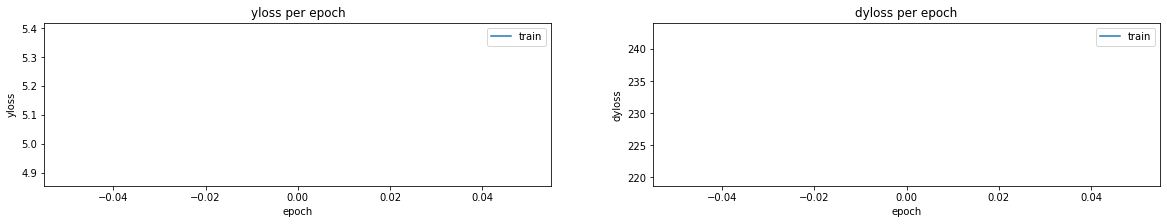

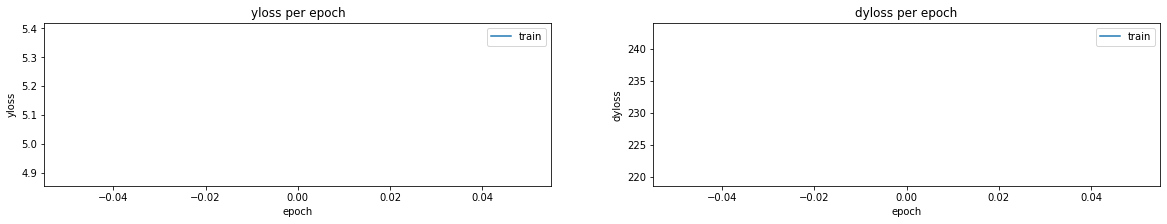

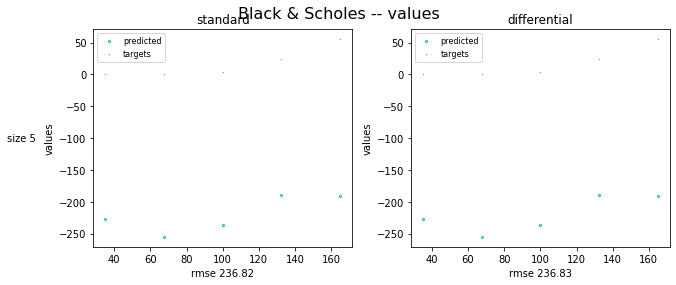

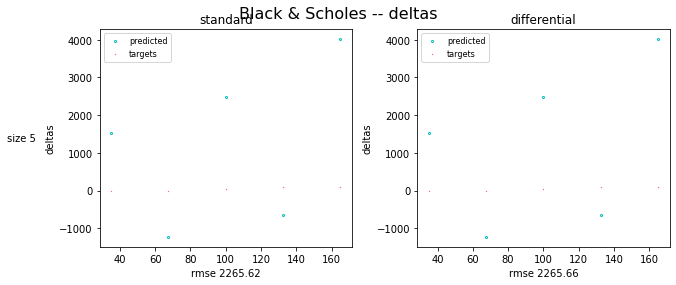

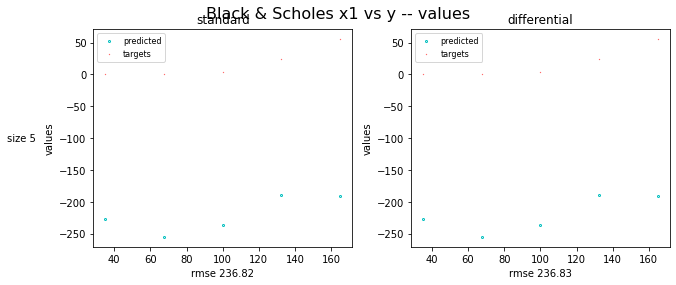

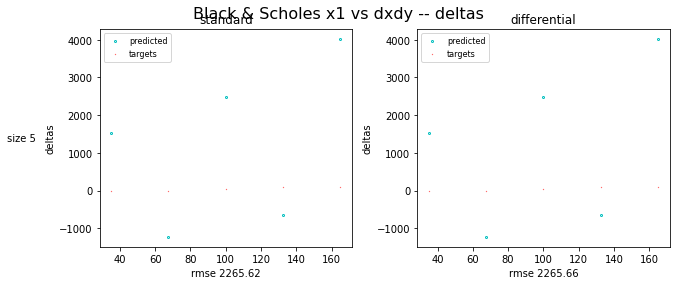

In [42]:
key3 = "no_normalize"
stats_dic[key1_1][key2][key3] = [None, None]
stats_dic[key1_2][key2][key3] = [None, None]
tests_loss[key1_1][key2][key3] = [None, None]
tests_loss[key1_2][key2][key3] = [None, None]

model, loss = run_diffML_train(
              name = graph_name, 
              generator = generator, 
              generator_kwargs = generator_kwargs ,
              show_graph_per_axis = True, 
              input_dim = INPUT_DIM,
              siren = True, # Siren
              normalize = False
              )

stats_dic[key1_1][key2][key3][0] = stats_dic[key1_1][key2][key3][1] = model.stats["normal"]
stats_dic[key1_2][key2][key3][0] = stats_dic[key1_2][key2][key3][1] = model.stats["differential"]
tests_loss[key1_1][key2][key3][0] = tests_loss[key1_1][key2][key3][1] = loss["normal"]
tests_loss[key1_2][key2][key3][0] = tests_loss[key1_2][key2][key3][1] = loss["differential"]

### **3.2.2) normalize = True**

simulating training, valid and test sets
done
initializing neural appropximator
done

size 5


Epoch 0: y loss scaled : 5.960144996643066, dy loss _scaled : 63.982093811035156

y loss no scaled : 0.2855342626571655, dy loss no scaled : 98.61640930175781



test y loss : 0.10155860334634781, test dy loss : 158.98927307128906


Epoch 0: y loss scaled : 5.960258483886719, dy loss _scaled : 63.971778869628906

y loss no scaled : 0.2855396866798401, dy loss no scaled : 98.60052490234375



test y loss : 0.10155995935201645, test dy loss : 158.9906768798828


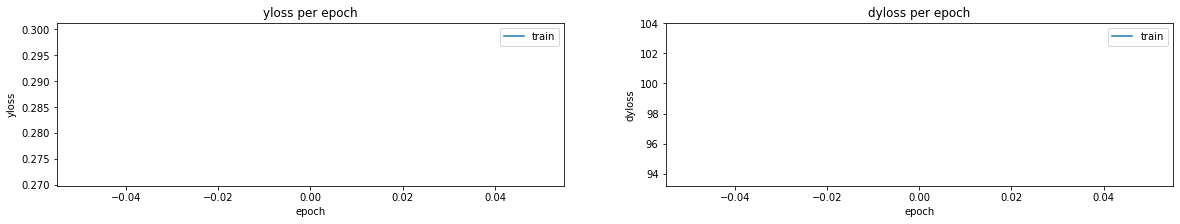

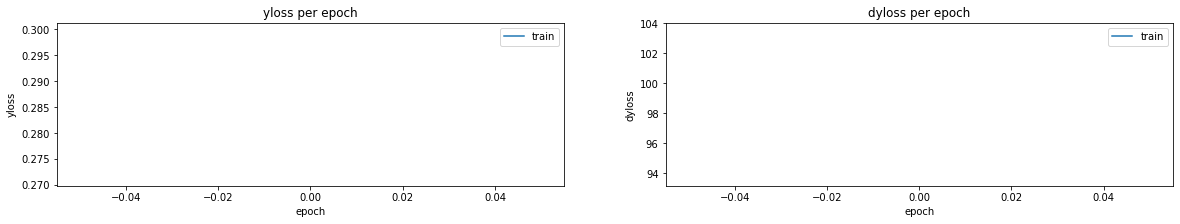

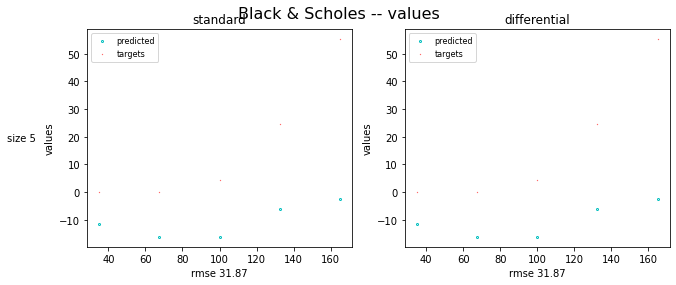

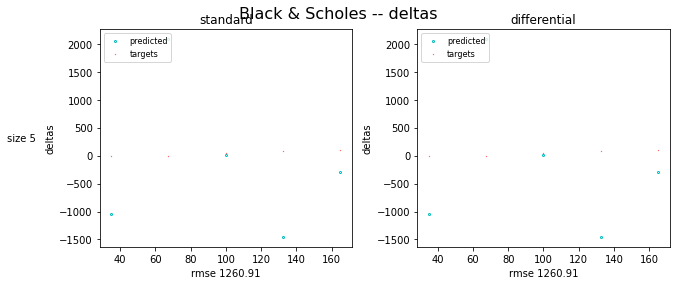

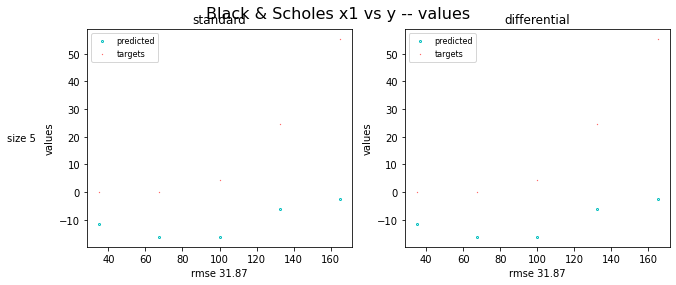

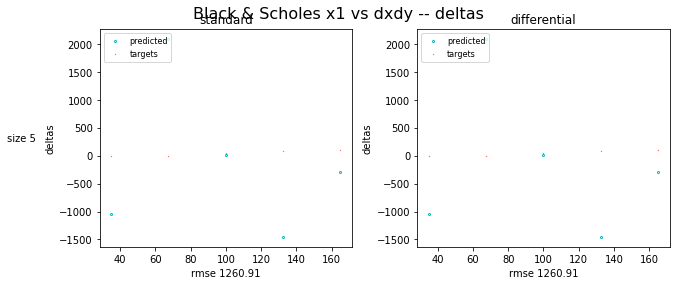

In [43]:
key3 = "normalize"
stats_dic[key1_1][key2][key3] = [None, None]
stats_dic[key1_2][key2][key3] = [None, None]
tests_loss[key1_1][key2][key3] = [None, None]
tests_loss[key1_2][key2][key3] = [None, None]

model, loss = run_diffML_train(
              name = graph_name, 
              generator = generator, 
              generator_kwargs = generator_kwargs ,
              show_graph_per_axis = True, 
              input_dim = INPUT_DIM,
              siren = True, # Siren
              normalize = True
              )

stats_dic[key1_1][key2][key3][0] = stats_dic[key1_1][key2][key3][1] = model.stats["normal"]
stats_dic[key1_2][key2][key3][0] = stats_dic[key1_2][key2][key3][1] = model.stats["differential"]
tests_loss[key1_1][key2][key3][0] = tests_loss[key1_1][key2][key3][1] = loss["normal"]
tests_loss[key1_2][key2][key3][0] = tests_loss[key1_2][key2][key3][1] = loss["differential"]

# **4) twin_net pytorch**

In [44]:
name = "twin_net"
with_derivative = True
key1 = "twin_net_pytorch"
stats_dic[key1] = {}
tests_loss[key1] = {}

## **4.1) with MLP**

In [45]:
model_class = MLP
key2 = "mlp"
stats_dic[key1][key2] = {}
tests_loss[key1][key2] = {}

### **4.1.1) normalize = False**

In [46]:
key3 = "no_normalize"
stats_dic[key1][key2][key3] = [None, None]
tests_loss[key1][key2][key3] = [None, None]

Epoch 0: train loss: 0.7518885135650635, y loss : 0.048481978476047516, dy loss : 0.7034065127372742

train loss no scaled: 0.7518884912133217, y loss  no scaled : 0.048481978476047516, dy loss  no scaled: 0.7034065127372742






test loss: 0.44174066185951233, y loss : 0.06439083069562912, dydx loss : 0.3773498237133026

test loss no scaled: 0.44174065440893173, y loss  no scaled : 0.06439083069562912, dydx loss  no scaled: 0.3773498237133026




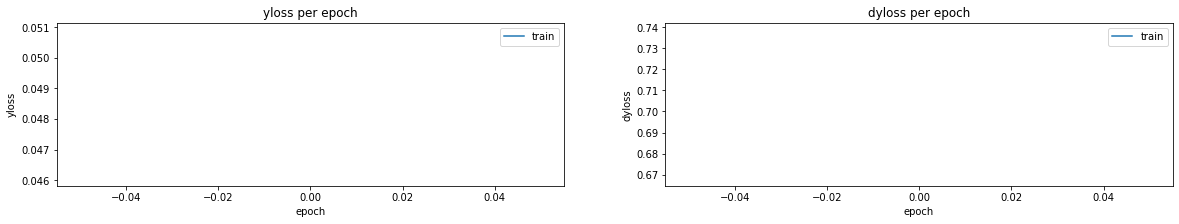

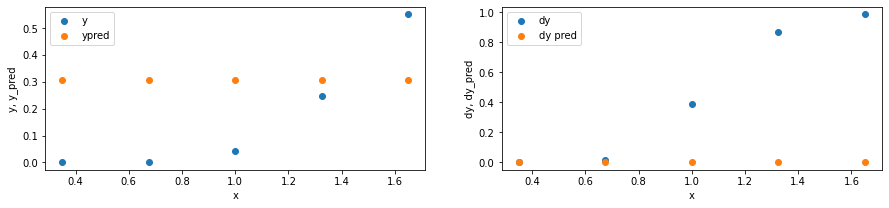

In [47]:
model, tests_loss[key1][key2][key3][0], stats_dic[key1][key2][key3][0] = run_train(
    name = name, 
    generator = generator, 
    with_derivative = with_derivative, 
    model_class = model_class, 
    model_kwargs = mlp_model_kwargs,
    normalize = False, 
    learning_rate_schedule = None)

Epoch 0: train loss: 1.4094727039337158, y loss : 0.706388533115387, dy loss : 0.7030841112136841

train loss no scaled: 1.409472644329071, y loss  no scaled : 0.706388533115387, dy loss  no scaled: 0.7030841112136841






test loss: 0.8434195518493652, y loss : 0.4663005769252777, dydx loss : 0.3771189749240875

test loss no scaled: 0.8434195518493652, y loss  no scaled : 0.4663005769252777, dydx loss  no scaled: 0.3771189749240875




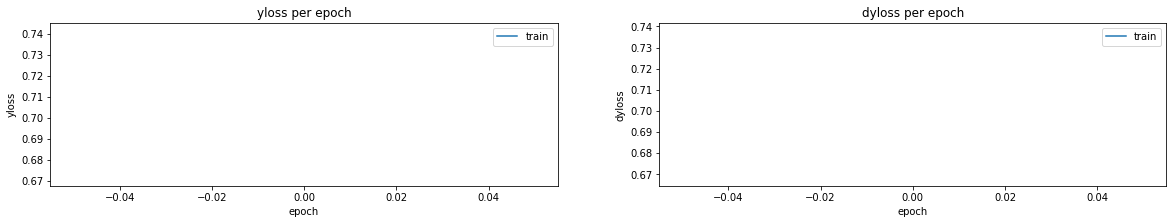

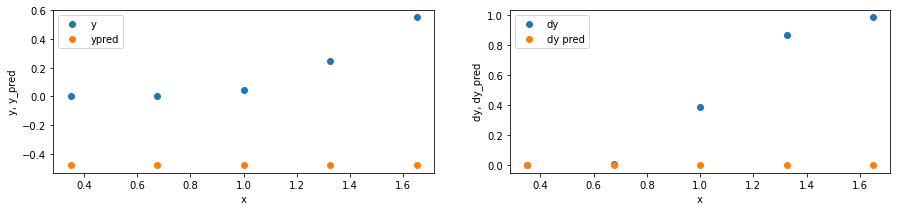

In [48]:
model, tests_loss[key1][key2][key3][1], stats_dic[key1][key2][key3][1] = run_train(
    name = name, 
    generator = generator, 
    with_derivative = with_derivative, 
    model_class = model_class, 
    model_kwargs = mlp_model_kwargs,
    normalize = False, 
    learning_rate_schedule = learning_rate_schedule)

### **4.1.2) normalize = True**

In [49]:
key3 = "normalize"
stats_dic[key1][key2][key3] = [None, None]
tests_loss[key1][key2][key3] = [None, None]

Epoch 0: train loss: 2.1170802116394043, y loss : 1.1170800924301147, dy loss : 1.000000238418579

train loss no scaled: 0.19998749927946508, y loss  no scaled : 0.0535162586050305, dy loss  no scaled: 0.14647124067443457






test loss: 3.8694088241523503, y loss : 2.101524647871931, dydx loss : 1.7678841762804192

test loss no scaled: 0.35962243220277657, y loss  no scaled : 0.10067830471600486, dydx loss  no scaled: 0.2589441274867717




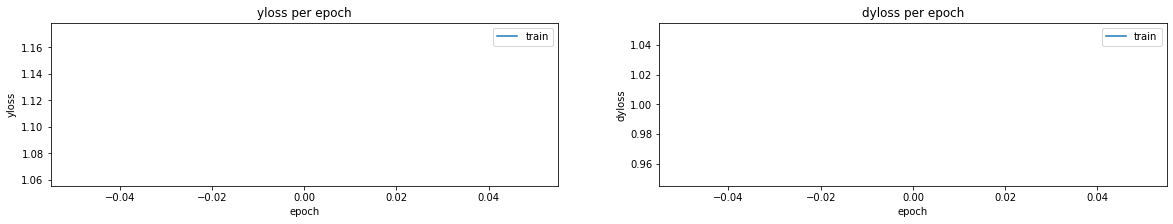

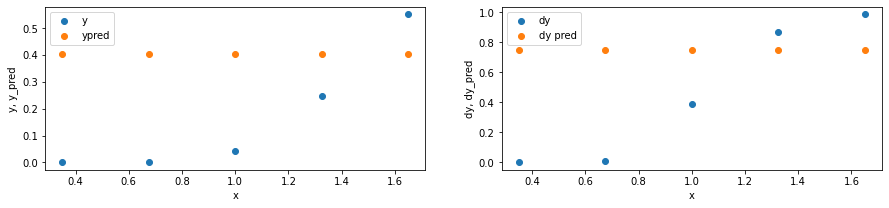

In [50]:
model, tests_loss[key1][key2][key3][0], stats_dic[key1][key2][key3][0] = run_train(
    name = name, 
    generator = generator, 
    with_derivative = with_derivative, 
    model_class = model_class, 
    model_kwargs = mlp_model_kwargs,
    normalize = True, 
    learning_rate_schedule = None)

Epoch 0: train loss: 2.023129940032959, y loss : 1.0231300592422485, dy loss : 1.0

train loss no scaled: 0.19548657206891745, y loss  no scaled : 0.04901536168127205, dy loss  no scaled: 0.1464712103876454






test loss: 3.493526145568798, y loss : 1.7256905510243576, dydx loss : 1.7678355945444406

test loss no scaled: 0.341610131540011, y loss  no scaled : 0.08267311987870078, dydx loss  no scaled: 0.2589370116613102




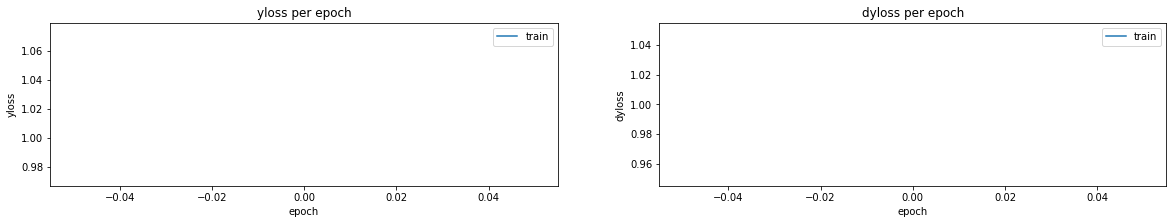

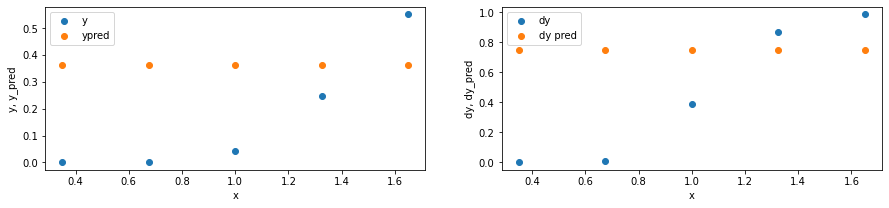

In [51]:
model, tests_loss[key1][key2][key3][1], stats_dic[key1][key2][key3][1] = run_train(
    name = name, 
    generator = generator, 
    with_derivative = with_derivative, 
    model_class = model_class, 
    model_kwargs = mlp_model_kwargs,
    normalize = True, 
    learning_rate_schedule = learning_rate_schedule)

## **4.2) with Siren**

In [52]:
model_class = Siren
key2 = "siren"
stats_dic[key1][key2] = {}
tests_loss[key1][key2] = {}

### **4.2.1) normalize = False**

In [53]:
key3 = "no_normalize"
stats_dic[key1][key2][key3] = [None, None]
tests_loss[key1][key2][key3] = [None, None]

Epoch 0: train loss: 1.1025288105010986, y loss : 0.08858983218669891, dy loss : 1.0139390230178833

train loss no scaled: 1.1025288552045822, y loss  no scaled : 0.08858983218669891, dy loss  no scaled: 1.0139390230178833






test loss: 0.95273756980896, y loss : 0.04832957312464714, dydx loss : 0.9044079780578613

test loss no scaled: 0.9527375511825085, y loss  no scaled : 0.04832957312464714, dydx loss  no scaled: 0.9044079780578613




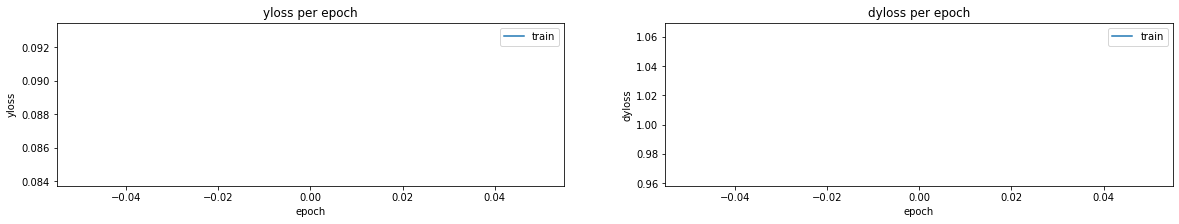

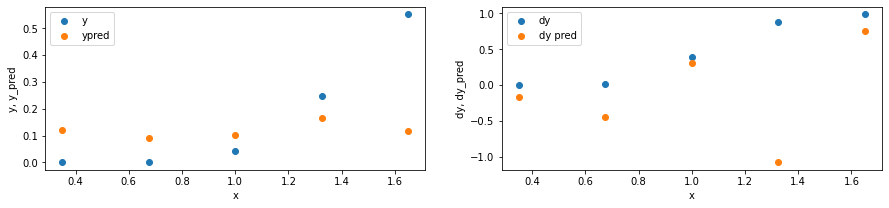

In [54]:
model, tests_loss[key1][key2][key3][0], stats_dic[key1][key2][key3][0] = run_train(
    name = name, 
    generator = generator, 
    with_derivative = with_derivative, 
    model_class = model_class, 
    model_kwargs = siren_model_kwargs,
    normalize = False, 
    learning_rate_schedule = None)

Epoch 0: train loss: 1.2824137210845947, y loss : 0.0741085410118103, dy loss : 1.2083052396774292

train loss no scaled: 1.2824137806892395, y loss  no scaled : 0.0741085410118103, dy loss  no scaled: 1.2083052396774292






test loss: 1.2938652038574219, y loss : 0.045357685536146164, dydx loss : 1.2485074996948242

test loss no scaled: 1.2938651852309704, y loss  no scaled : 0.045357685536146164, dydx loss  no scaled: 1.2485074996948242




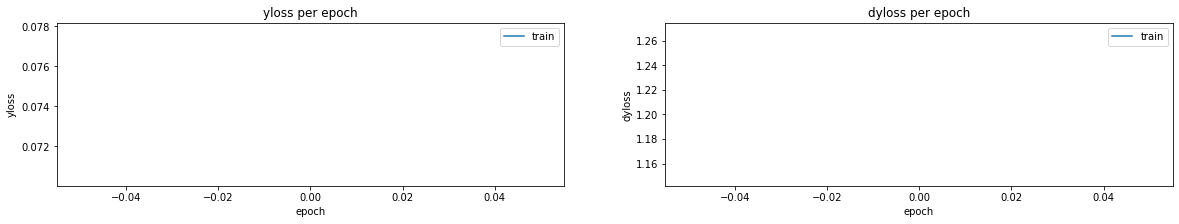

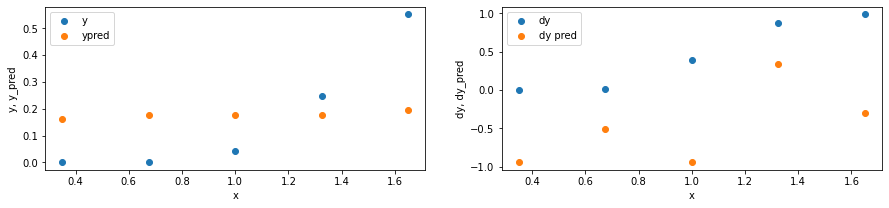

In [55]:
model, tests_loss[key1][key2][key3][1], stats_dic[key1][key2][key3][1] = run_train(
    name = name, 
    generator = generator, 
    with_derivative = with_derivative, 
    model_class = model_class, 
    model_kwargs = siren_model_kwargs,
    normalize = False, 
    learning_rate_schedule = learning_rate_schedule)

### **4.2.2) normalize = True**

In [56]:
key3 = "normalize"
stats_dic[key1][key2][key3] = [None, None]
tests_loss[key1][key2][key3] = [None, None]

Epoch 0: train loss: 2.8626396656036377, y loss : 1.0277693271636963, dy loss : 1.8348703384399414

train loss no scaled: 0.3179932858616746, y loss  no scaled : 0.04923762029514363, dy loss  no scaled: 0.26875566556653097






test loss: 4.594955671869923, y loss : 1.2612954069008575, dydx loss : 3.3336602649690654

test loss no scaled: 0.5487104568347415, y loss  no scaled : 0.06042521720668415, dydx loss  no scaled: 0.4882852396280573




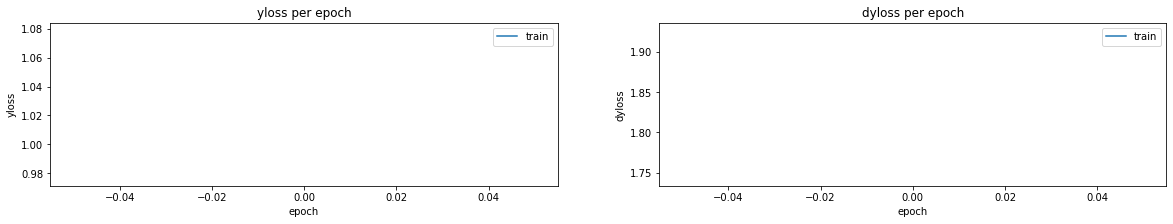

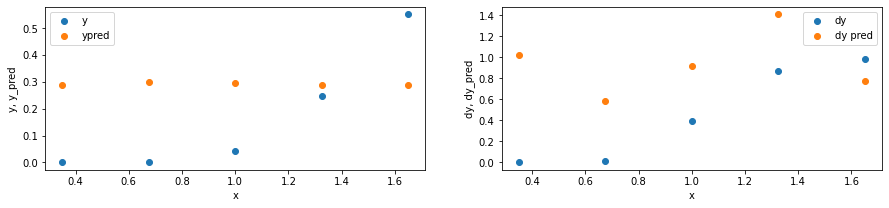

In [57]:
model, tests_loss[key1][key2][key3][0], stats_dic[key1][key2][key3][0] = run_train(
    name = name, 
    generator = generator, 
    with_derivative = with_derivative, 
    model_class = model_class, 
    model_kwargs = siren_model_kwargs,
    normalize = True, 
    learning_rate_schedule = None)

Epoch 0: train loss: 2.2208075523376465, y loss : 1.0202335119247437, dy loss : 1.2005741596221924

train loss no scaled: 0.2247261302692366, y loss  no scaled : 0.04887659967201623, dy loss  no scaled: 0.1758495305972204






test loss: 2.9593542890748243, y loss : 1.2655970975174307, dydx loss : 1.6937571915573937

test loss no scaled: 0.3087179580845895, y loss  no scaled : 0.06063129945231848, dydx loss  no scaled: 0.24808665863227106




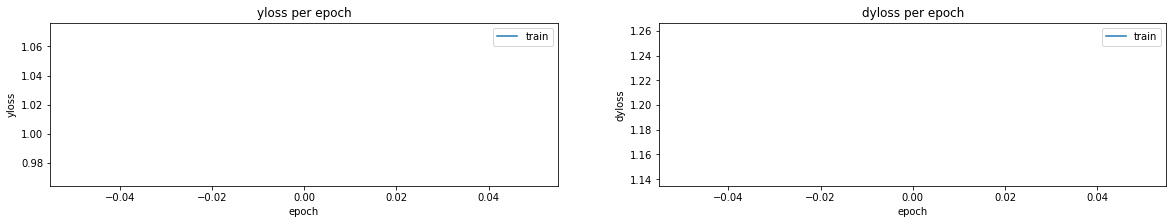

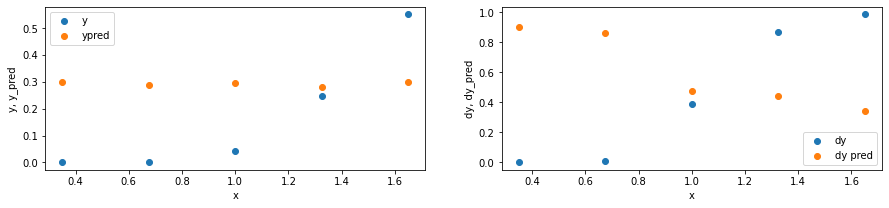

In [58]:
model, tests_loss[key1][key2][key3][1], stats_dic[key1][key2][key3][1] = run_train(
    name = name, 
    generator = generator, 
    with_derivative = with_derivative, 
    model_class = model_class, 
    model_kwargs = siren_model_kwargs,
    normalize = True, 
    learning_rate_schedule = learning_rate_schedule)

# **5) Global Stats**

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


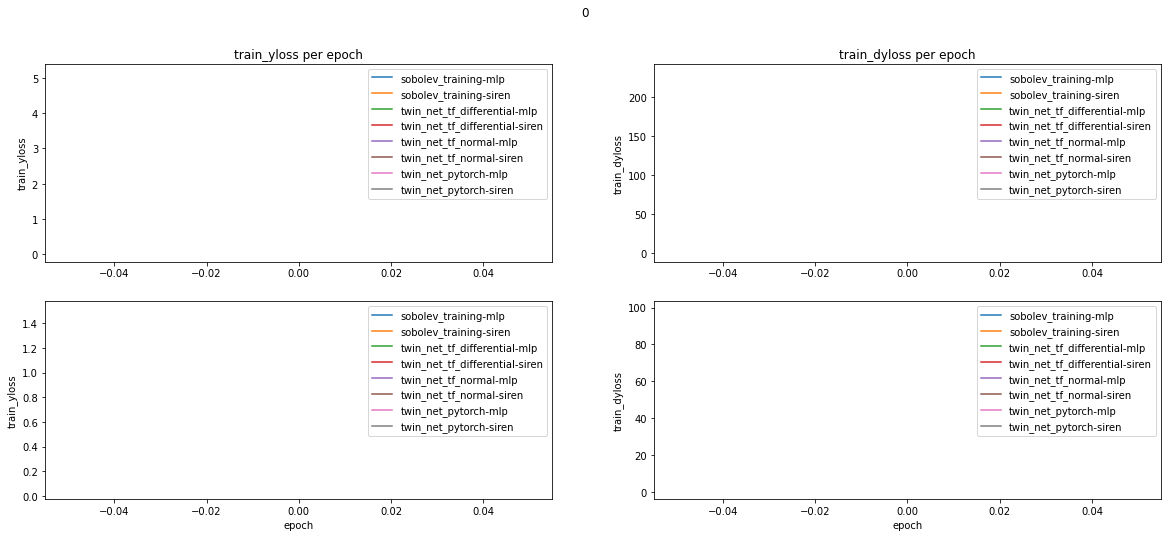

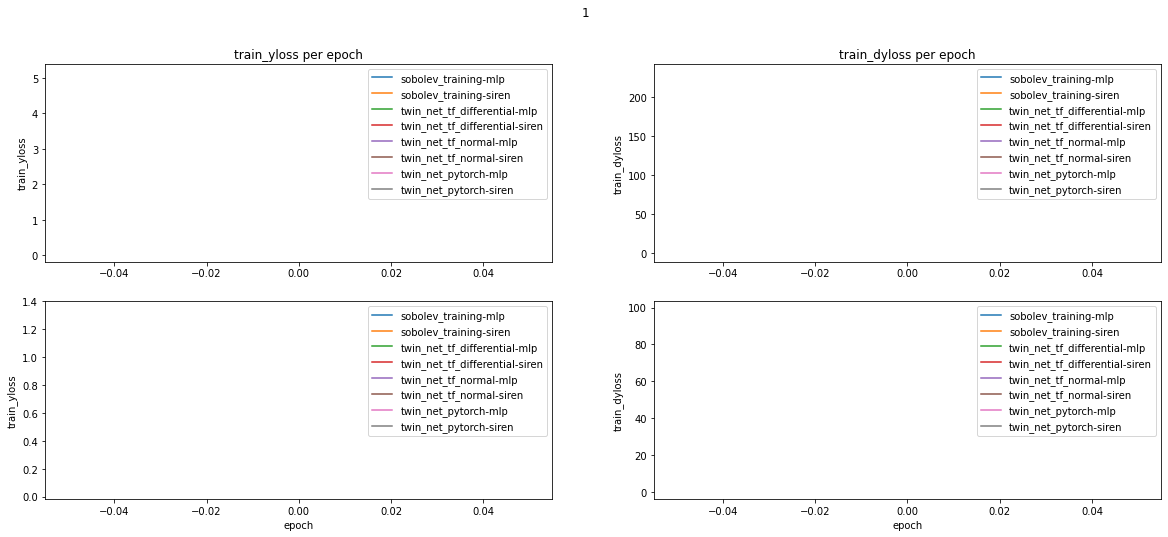

In [59]:
global_stat(stats_dic, suptitle = graph_name)

In [61]:
rows, result = to_csv(dico = tests_loss, csv_path = csv_path, n_samples = str(nTrain), mode='a+')